# Модели машинного обучения

In [1]:
import warnings

import glob

from tqdm import tqdm

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

from skopt import BayesSearchCV

warnings.filterwarnings("ignore")

In [2]:
DATASETS_DIR = "./datasets/aump"
Q = [0.2, 0.4, 0.6, 0.8]
files = glob.glob(DATASETS_DIR + "/**/*.csv", recursive=True)
print("\n".join(files))

./datasets/aump\data_0_2.csv
./datasets/aump\data_0_4.csv
./datasets/aump\data_0_6.csv
./datasets/aump\data_0_8.csv


## CatBoost

100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


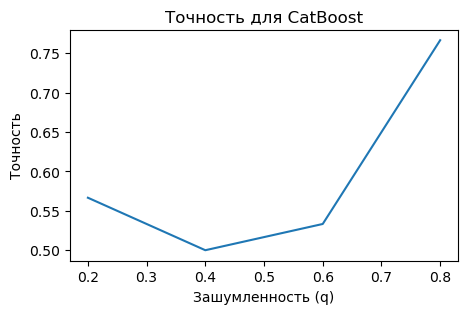

In [117]:
LEARNING_RATE = 0.4

catboost_model = CatBoostClassifier(
    task_type="GPU",
    iterations=300,
    od_wait=10,
    od_type="Iter",
    learning_rate=LEARNING_RATE,
    allow_writing_files=False,
    silent=True,
)

catboost_accuracy_list = []

for file in tqdm(files):
    df = pd.read_csv(file)
    y = df["target"]
    X = df.drop("target", axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    catboost_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)
    catboost_accuracy_list.append(accuracy_score(y_test, catboost_model.predict(X_test)))

plt.figure(figsize=(5,3))
plt.title("Точность для CatBoost")
plt.ylabel("Точность")
plt.xlabel("Зашумленность (q)")
plt.plot(Q, catboost_accuracy_list)
plt.show()

## SVM

### Линейный метод SVM

In [8]:
linear_svm_bcv = BayesSearchCV(estimator=LinearSVC(), search_spaces={
   "C": [x / 10 for x in range(1, 11, 1)],
   "max_iter": [x for x in range(10, 100, 10)],
   "loss": ["hinge", "squared_hinge"],
}, scoring="accuracy", n_jobs=-1)

In [9]:
linear_svm_accuracy_list = []

for file in tqdm(files):
    df = pd.read_csv(file)
    y = df["target"]
    X = df.drop("target", axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    linear_svm_bcv.fit(X_train, y_train)
    best_liner_svm = linear_svm_bcv.best_estimator_
    linear_svm_accuracy_list.append(cross_val_score(best_liner_svm, X_test, y_test, scoring="accuracy", n_jobs=-1).mean())

100%|██████████| 4/4 [02:47<00:00, 41.93s/it]


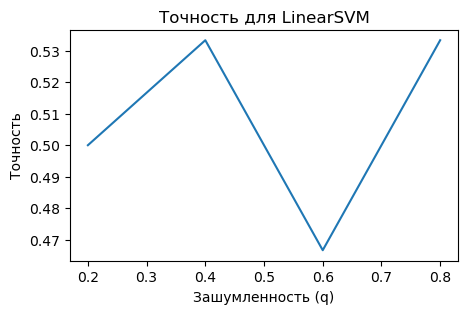

In [12]:
plt.figure(figsize=(5,3))
plt.title("Точность для LinearSVM")
plt.ylabel("Точность")
plt.xlabel("Зашумленность (q)")
plt.plot(Q, linear_svm_accuracy_list)
plt.show()

## Нелинейный SVM

In [13]:
svc_bcv = BayesSearchCV(estimator=SVC(), search_spaces={
    "C": [x / 10 for x in range(1, 11, 1)],
    "max_iter": [x for x in range(10, 100, 10)],
}, scoring="accuracy", n_jobs=-1)

In [20]:
svc_bcv = BayesSearchCV(estimator=SVC(), search_spaces={
    "C": [x / 10 for x in range(1, 11, 1)],
    "max_iter": [x for x in range(10, 100, 10)],
}, scoring="accuracy", n_jobs=-1)

svm_accuracy_list = []

for file in tqdm(files):
    df = pd.read_csv(file)
    y = df["target"]
    X = df.drop("target", axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    svc_bcv.fit(X_train, y_train)
    best_svm = svc_bcv.best_estimator_
    svm_accuracy_list.append(cross_val_score(best_svm, X_test, y_test, scoring="accuracy", n_jobs=-1).mean())

100%|██████████| 4/4 [01:56<00:00, 29.23s/it]


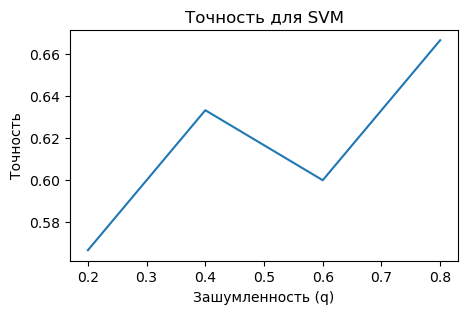

In [21]:
plt.figure(figsize=(5,3))
plt.title("Точность для SVM")
plt.ylabel("Точность")
plt.xlabel("Зашумленность (q)")
plt.plot(Q, svm_accuracy_list)
plt.show()